##PCA
Assume that we are performing PCA on
some dataset $\boldsymbol X$ for $M$ principal components. 
We then need to perform the following steps, which we break into parts:

1. Data normalization (`normalize`).
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix $S$.
   Sort by the largest eigenvalues and the corresponding eigenvectors (`eig`).

After these steps, we can then compute the projection and reconstruction of the data onto the spaced spanned by the top $n$ eigenvectors.

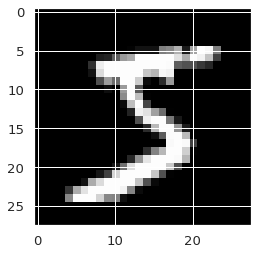

In [83]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)
import tensorflow as tf
 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
plt.figure(figsize=(4,4))
plt.imshow(X_train[0].reshape(28,28), cmap='gray')
plt.show()

In [84]:
def normalize(X):
  mu = np.mean(X, axis=0)
  std = np.std(X, axis=0)
  std_filled = std.copy()
  std_filled[std==0] = 1.
  Xbar = ((X-mu)/std_filled)
  return Xbar, mu, std

def eig(S):
  eigvals, eigvecs = np.linalg.eig(S)
  k = np.argsort(eigvals)[::-1]
  return eigvals[k], eigvecs[:,k]

def projection_matrix(B):
  return (B @ np.linalg.inv(B.T @ B) @ B.T)

def PCA(X, num_components):
  S = 1.0/len(X) * np.dot(X.T, X) # covariance matrix
  eig_vals, eig_vecs = eig(S)
  eig_vals, eig_vecs = eig_vals[:num_components], eig_vecs[:, :num_components]
  B = np.real(eig_vecs)
  reconst = (projection_matrix(B) @ X.T)
  return reconst.T


In [85]:
NUM_DATAPOINTS = 100
X = (X_train[100].reshape(28,28))
#X = (X_train.reshape(-1, 28 * 28)[:NUM_DATAPOINTS]) / 255.
Xbar, mu, std = normalize(X)

In [86]:
def mse(predict, actual):
    return np.square(predict - actual).sum(axis=1).mean()

In [87]:
reconstructions = []
loss = []

# iterate over different numbers of principal components, and compute the MSE
for num_component in range(0, 100):
    reconst = PCA(Xbar, num_component)
    error = mse(reconst, Xbar)
    reconstructions.append(reconst)
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
print(len(reconstructions))
reconstructions = reconstructions * std + mu
loss = np.asarray(loss)

100


In [88]:
import pandas as pd
# create a table showing the number of principal components and MSE
pd.DataFrame(loss).head()

,0,1
0,0.0,12.000000
1,1.0,7.347112
2,2.0,3.647518
3,3.0,1.557369
4,4.0,0.653536


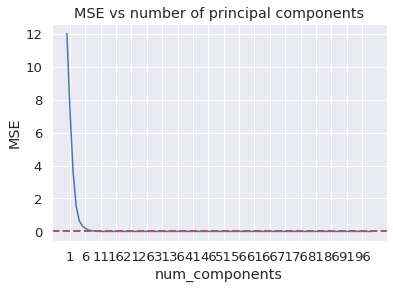

In [89]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(0, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, 100, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

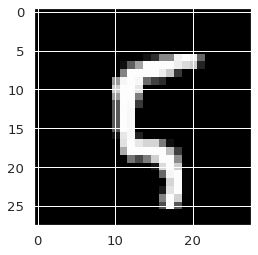

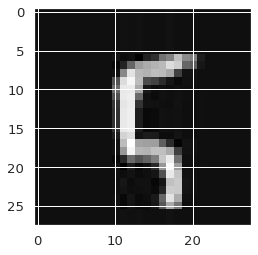

In [90]:
plt.figure(figsize=(4,4))
actual_sample = X.reshape(28,28)
reconst_sample = (reconstructions[6] * std + mu).reshape(28, 28)
plt.imshow(actual_sample, cmap='gray')
plt.show()
plt.imshow(reconst_sample, cmap='gray')
plt.show()

##PCA for high-dimensional datasets

Sometimes, the dimensionality of our dataset may be larger than the number of samples we
have. Then it might be inefficient to perform PCA with our implementation above. Instead,
we can implement PCA in a more efficient manner, which we call "PCA for high dimensional data" (PCA_high_dim).

Below are the steps for performing PCA for high dimensional dataset
1. Compute the matrix $\boldsymbol X\boldsymbol X^T$ (a $N$ by $N$ matrix with $N \ll D$)
2. Compute eigenvalues $\lambda$s and eigenvectors $V$ for $\boldsymbol X\boldsymbol X^T$
3. Compute the eigenvectors for the original covariance matrix as $\boldsymbol X^T\boldsymbol V$. Choose the eigenvectors associated with the M largest eigenvalues to be the basis of the principal subspace $U$.
4. Compute the orthogonal projection of the data onto the subspace spanned by columns of $\boldsymbol U$.

In [98]:
def PCA_high_dim(X, n_components):
  N, D = X.shape
  M = np.dot(X, X.T) / N
  eig_vals, eig_vecs = eig(M)
  eig_vals, eig_vecs = eig_vals[:n_components], eig_vecs[:, :n_components]
  U = (X.T @ (eig_vecs))
  #answer = np.zeros((N, D))
  answer = ((U @ np.linalg.inv(U.T @ U) @ U.T) @ X.T).T
  #B = np.real(eig_vecs)
    # Z = X.T.dot(W)
    # reconstruct the images from the lower dimensional representation
  #reconst = (projection_matrix(B) @ X.T) @ np.linalg.inv(X.T @ X) @ X.T
  return answer

In [99]:
#np.testing.assert_almost_equal(PCA(Xbar, 2), PCA_high_dim(Xbar, 2))

In [93]:
import timeit
def time(f, repeat=10):
    times = []
    for _ in range(repeat):
        start = timeit.default_timer()
        f()
        stop = timeit.default_timer()
        times.append(stop-start)
    return np.mean(times), np.std(times)

In [100]:
times_mm0 = []
times_mm1 = []

# iterate over datasets of different size
for datasetsize in np.arange(4, 784, step=20):
    XX = Xbar[:datasetsize] # select the first `datasetsize` samples in the dataset
    # record the running time for computing X.T @ X
    mu, sigma = time(lambda : XX.T @ XX)
    times_mm0.append((datasetsize, mu, sigma))
    
    # record the running time for computing X @ X.T
    mu, sigma = time(lambda : XX @ XX.T)
    times_mm1.append((datasetsize, mu, sigma))
    
times_mm0 = np.asarray(times_mm0)
times_mm1 = np.asarray(times_mm1)

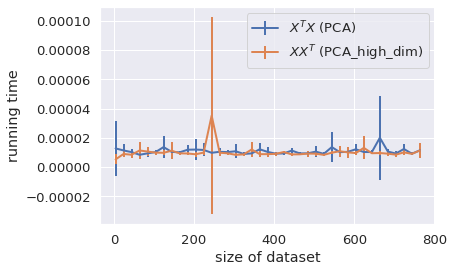

In [101]:
fig, ax = plt.subplots()
ax.set(xlabel='size of dataset', ylabel='running time')
bar = ax.errorbar(times_mm0[:, 0], times_mm0[:, 1], times_mm0[:, 2], label="$X^T X$ (PCA)", linewidth=2)
ax.errorbar(times_mm1[:, 0], times_mm1[:, 1], times_mm1[:, 2], label="$X X^T$ (PCA_high_dim)", linewidth=2)
ax.legend();

In [102]:
%time Xbar.T @ Xbar
%time Xbar @ Xbar.T
pass # Put this here so that our output does not show result of computing `Xbar @ Xbar.T`

CPU times: user 758 µs, sys: 0 ns, total: 758 µs
Wall time: 681 µs
CPU times: user 916 µs, sys: 0 ns, total: 916 µs
Wall time: 857 µs


In [103]:
times0 = []
times1 = []

# iterate over datasets of different size
for datasetsize in np.arange(4, 784, step=100):
    XX = Xbar[:datasetsize]
    npc = 2
    mu, sigma = time(lambda : PCA(XX, npc), repeat=10)
    times0.append((datasetsize, mu, sigma))
    
    mu, sigma = time(lambda : PCA_high_dim(XX, npc), repeat=10)
    times1.append((datasetsize, mu, sigma))
    
times0 = np.asarray(times0)
times1 = np.asarray(times1)

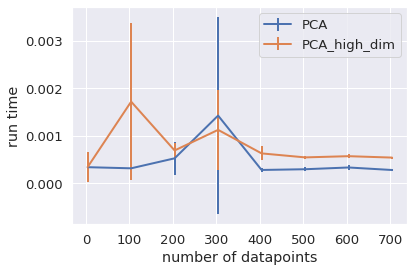

In [104]:
fig, ax = plt.subplots()
ax.set(xlabel='number of datapoints', ylabel='run time')
ax.errorbar(times0[:, 0], times0[:, 1], times0[:, 2], label="PCA", linewidth=2)
ax.errorbar(times1[:, 0], times1[:, 1], times1[:, 2], label="PCA_high_dim", linewidth=2)
ax.legend();

In [105]:
%time PCA(Xbar, 2)
%time PCA_high_dim(Xbar, 2)
pass

CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 1.9 ms
CPU times: user 3.5 ms, sys: 2.89 ms, total: 6.39 ms
Wall time: 7.93 ms
